<a href="https://colab.research.google.com/github/Pmskabir1234/Torch/blob/main/telescope_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install opendatasets
import opendatasets as od
od.download("https://www.kaggle.com/datasets/abhinand05/magic-gamma-telescope-dataset")


Skipping, found downloaded files in "./magic-gamma-telescope-dataset" (use force=True to force download)


In [ ]:
import torch
import pandas as pd
import numpy as np
from torch import nn

In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

cpu


In [ ]:
df = pd.read_csv("/content/telescope_data.csv")
df = df.drop('Unnamed: 0', axis = 1)
df['class'].value_counts()

#normalisation
for column in df.columns[:-1]:
  df[column] = df[column]/df[column].abs().max()

X = df.drop('class', axis = 1)
y = (df['class'] == 'g').astype(int)



In [ ]:
from imblearn.over_sampling import RandomOverSampler
def oversampling(X,y):
  ros = RandomOverSampler()
  X,y = ros.fit_resample(X,y)
  return X,y

X,y = oversampling(X,y)
y.value_counts()


,count
class,
1,12332
0,12332


In [ ]:
from torch.utils.data import DataLoader, Dataset

class dataset(Dataset):
  def __init__(self,X,y):
    self.X = torch.tensor(X, dtype=torch.float32).to(device)
    self.y = torch.tensor(y, dtype=torch.float32).to(device)

  def __len__(self):
    return len(self.X)

  def __getitem__(self, index):
    return self.X[index], self.y[index]



In [ ]:
X = X.to_numpy()
y = y.to_numpy()

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X,y,test_size = 0.3)
X_test, X_val, y_test, y_val = train_test_split(X_test,y_test,test_size = 0.5)

print(X_train.shape)
print(X_test.shape)
print(X_val.shape)

(17264, 10)
(3700, 10)
(3700, 10)


In [ ]:
train_dataset = dataset(X_train,y_train)
val_dataset = dataset(X_val,y_val)
test_dataset = dataset(X_test,y_test)

In [ ]:
train_data = DataLoader(train_dataset, batch_size = 16, shuffle = True)
val_data = DataLoader(val_dataset, batch_size = 16, shuffle = True)
test_data = DataLoader(test_dataset, batch_size = 16, shuffle = True)

for x,y in train_data:
  print(x)
  print("=====")
  print(y)
  break
X_val.shape

tensor([[ 7.7886e-02,  2.8867e-02,  4.5504e-01,  6.9362e-01,  5.6146e-01,
         -4.8444e-02,  4.2312e-02, -6.3130e-02,  7.1954e-01,  3.7582e-01],
        [ 1.1053e-01,  9.6332e-02,  5.7609e-01,  2.6215e-01,  1.8987e-01,
          3.6287e-03, -6.2765e-02,  9.3080e-02,  2.6836e-02,  3.1892e-01],
        [ 2.5724e-01,  2.3318e-01,  6.0072e-01,  2.5174e-01,  1.7684e-01,
         -3.0143e-01,  2.8185e-01, -8.8098e-02,  1.9471e-01,  4.0707e-01],
        [ 8.1646e-02,  8.0323e-02,  5.4111e-01,  3.9664e-01,  2.9547e-01,
         -2.7489e-02, -5.6292e-02,  7.5130e-02,  1.1403e-01,  2.8096e-01],
        [ 1.2046e-01,  4.8440e-02,  5.2148e-01,  3.9395e-01,  2.9887e-01,
          1.6200e-03,  6.0025e-02, -4.8473e-02,  4.9894e-01,  5.2008e-01],
        [ 7.1471e-02,  3.8403e-02,  4.0311e-01,  6.3359e-01,  4.6712e-01,
          2.2146e-02,  7.6404e-02, -1.3815e-02,  4.8244e-02,  2.5827e-01],
        [ 1.8114e-01,  1.3621e-01,  5.7175e-01,  3.0594e-01,  2.5918e-01,
         -6.8789e-02,  1.3711e-0

(3700, 10)

In [ ]:
HIDDEN_NEURONS = 10
class model(nn.Module):
  def __init__(self):
    super(model,self).__init__()

    self.in_linear = nn.Linear(X.shape[1],HIDDEN_NEURONS)
    self.linear1 = nn.Linear(HIDDEN_NEURONS, 10)
    self.relu = nn.ReLU()
    self.linear2 = nn.Linear(10, 1)
    self.sigmoid = nn.Sigmoid()

  def forward(self, x):
    x = self.in_linear(x)
    x = self.linear1(x)
    x = self.relu(x)
    x = self.linear2(x)
    x = self.sigmoid(x)

    return x

model = model().to(device)

In [ ]:
criterion = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr = 1e-3)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=1, gamma=1.1) # Increase LR by 10% each epoch

In [ ]:
from torchsummary import summary
summary = summary(model, (X.shape[1],))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                   [-1, 10]             110
            Linear-2                   [-1, 10]             110
              ReLU-3                   [-1, 10]               0
            Linear-4                    [-1, 1]              11
           Sigmoid-5                    [-1, 1]               0
Total params: 231
Trainable params: 231
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.00
Estimated Total Size (MB): 0.00
----------------------------------------------------------------


In [ ]:
print(val_data.__len__())

232


In [ ]:
epochs = 20
total_train_loss_plot = []
total_train_acc_plot = []
total_val_loss_plot = []
total_val_acc_plot = []

for epoch in range(epochs):
  total_train_loss = 0
  total_train_acc = 0
  total_val_loss = 0
  total_val_acc = 0

  for data in train_data:
    input, label = data

    prediction = model(input).squeeze(1)
    batch_loss = criterion(prediction, label)

    total_train_loss += batch_loss.item()

    acc = ((prediction).round() == label).sum().item()
    total_train_acc += acc

    batch_loss.backward()
    optimizer.step()
    optimizer.zero_grad()

  # Step the scheduler at the end of the epoch
  scheduler.step()

  with torch.no_grad():
    for data in val_data:
      input, label = data

      prediction = model(input).squeeze(1)
      batch_loss = criterion(prediction, label)

      total_val_loss += batch_loss.item()

      acc = ((prediction).round() == label).sum().item()
      total_val_acc += acc


  total_train_loss_plot.append(round(total_train_loss/1000, 4))
  total_train_acc_plot.append(round(total_train_acc/len(train_dataset) * 100, 4))
  total_val_loss_plot.append(round(total_val_loss/1000, 4))
  total_val_acc_plot.append(round(total_val_acc/len(val_dataset) * 100, 4))

  print(f"""Epoch no: {epoch+1} Train Loss: {round(total_train_loss/1000, 4)} Train Accuracy: {round(total_train_acc/len(train_dataset)*100, 4)}
        Validation Loss: {round(total_val_loss/1000, 4)} Validation Accuracy: {round(total_val_acc/len(val_dataset)*100, 4)}
        """
  )


Epoch no: 1 Train Loss: 0.4603 Train Accuracy: 79.4544
        Validation Loss: 0.0983 Validation Accuracy: 79.4054
        
Epoch no: 2 Train Loss: 0.4561 Train Accuracy: 79.883
        Validation Loss: 0.1019 Validation Accuracy: 79.1351
        
Epoch no: 3 Train Loss: 0.456 Train Accuracy: 79.9873
        Validation Loss: 0.0972 Validation Accuracy: 79.8378
        
Epoch no: 4 Train Loss: 0.4525 Train Accuracy: 80.1031
        Validation Loss: 0.0967 Validation Accuracy: 79.5135
        
Epoch no: 5 Train Loss: 0.4509 Train Accuracy: 80.4912
        Validation Loss: 0.0982 Validation Accuracy: 80.1892
        
Epoch no: 6 Train Loss: 0.4496 Train Accuracy: 80.6708
        Validation Loss: 0.0982 Validation Accuracy: 80.2703
        
Epoch no: 7 Train Loss: 0.4503 Train Accuracy: 80.3927
        Validation Loss: 0.1003 Validation Accuracy: 79.0541
        
Epoch no: 8 Train Loss: 0.4487 Train Accuracy: 80.7519
        Validation Loss: 0.098 Validation Accuracy: 79.3784
        
Epo

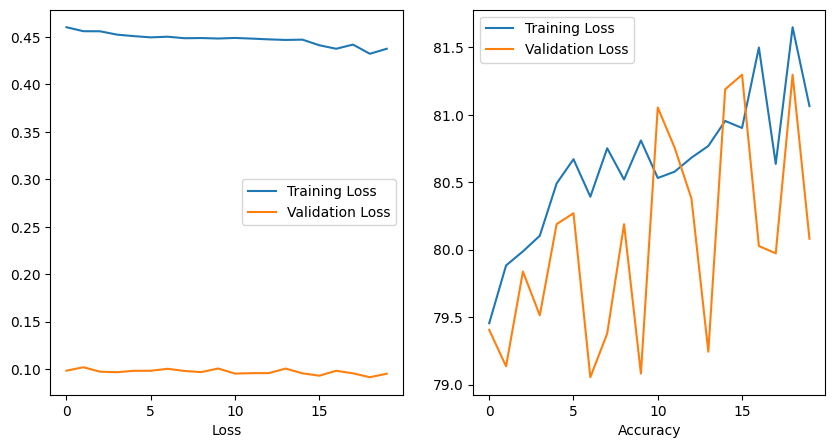

In [ ]:
import matplotlib.pyplot as plt

fig, axs = plt.subplots(1,2,figsize=(10,5))

axs[0].plot(total_train_loss_plot,label="Training Loss")
axs[0].plot(total_val_loss_plot, label ="Validation Loss")
axs[0].set_xlabel("Epoch")
axs[0].set_xlabel("Loss")
axs[0].legend()

axs[1].plot(total_train_acc_plot,label="Training Loss")
axs[1].plot(total_val_acc_plot, label ="Validation Loss")
axs[1].set_xlabel("Epoch")
axs[1].set_xlabel("Accuracy")
axs[1].legend()


In [ ]:
with torch.no_grad():
  total_test_loss = 0
  total_test_acc = 0


  for data in test_data:
    input, label = data

    prediction = model(input).squeeze(1)
    batch_loss = criterion(prediction, label)

    total_test_loss += batch_loss.item()

    acc = ((prediction).round() == label).sum().item()
    total_test_acc += acc

print(round(total_test_acc/len(test_dataset)*100, 4))




79.5676
